In TPOT1 you had to specify the feature subsets yourself. TPOT2 can identify the subsets using evolutionary algorithms.

In the future, FSS will be treated as a special case in the configuration dictionary to make it more efficient when there are large numbers of features.

In [4]:
import tpot2
import pandas as pd
import numpy as np
#make a dataframe with columns a,b,c,d,e,f

#numpy array where columns are 1,2,3,4,5,6
data = np.repeat([np.arange(6)],10,0)

df = pd.DataFrame(data,columns=['a','b','c','d','e','f'])
fss = tpot2.builtin_modules.FeatureSetSelector(name='test',sel_subset=['a','b','c'])

print("original DataFrame")
print(df)
print("Transformed Data")
print(fss.fit_transform(df))

original DataFrame
   a  b  c  d  e  f
0  0  1  2  3  4  5
1  0  1  2  3  4  5
2  0  1  2  3  4  5
3  0  1  2  3  4  5
4  0  1  2  3  4  5
5  0  1  2  3  4  5
6  0  1  2  3  4  5
7  0  1  2  3  4  5
8  0  1  2  3  4  5
9  0  1  2  3  4  5
Transformed Data
[[0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]]


0.7880069190851433


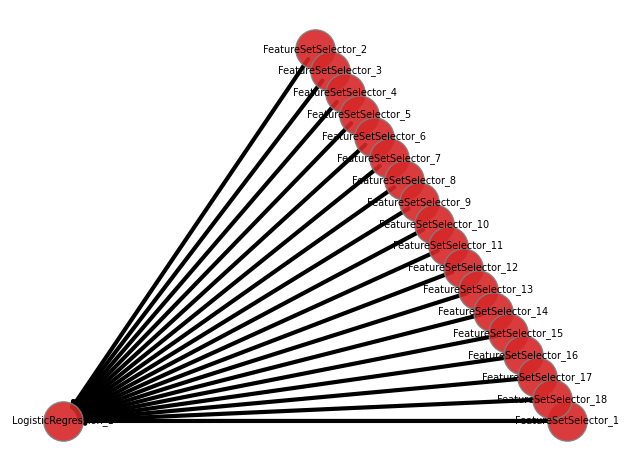

In [5]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np


def params_LogisticRegression(trial, name=None):
    params = {}
    params['solver'] = trial.suggest_categorical(name=f'solver_{name}',
                                                 choices=[f'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    params['dual'] = False
    params['penalty'] = 'l2'
    params['C'] = trial.suggest_float(f'C_{name}', 1e-4, 1e4, log=True)
    params['l1_ratio'] = None
    if params['solver'] == 'liblinear':
        params['penalty'] = trial.suggest_categorical(name=f'penalty_{name}', choices=['l1', 'l2'])
        if params['penalty'] == 'l2':
            params['dual'] = trial.suggest_categorical(name=f'dual_{name}', choices=[True, False])
        else:
            params['penalty'] = 'l1'

    params['class_weight'] = trial.suggest_categorical(name=f'class_weight_{name}', choices=['balanced'])
    param_grid = {'solver': params['solver'],
                  'penalty': params['penalty'],
                  'dual': params['dual'],
                  'multi_class': 'auto',
                  'l1_ratio': params['l1_ratio'],
                  'C': params['C'],
                  }
    return param_grid



root_config_dict =  {LogisticRegression: params_LogisticRegression}


est = tpot2.TPOTEstimator(population_size=40,generations=100, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict=None,
                            )

#make some data
n_features = 100
X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=n_features, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()

0.9999970586029246


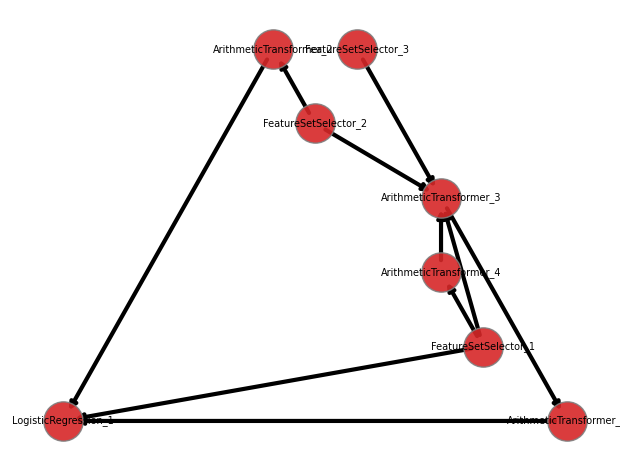

In [6]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

def params_LogisticRegression(trial, name=None):
    params = {}
    params['solver'] = trial.suggest_categorical(name=f'solver_{name}',
                                                 choices=[f'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    params['dual'] = False
    params['penalty'] = 'l2'
    params['C'] = trial.suggest_float(f'C_{name}', 1e-4, 1e4, log=True)
    params['l1_ratio'] = None
    if params['solver'] == 'liblinear':
        params['penalty'] = trial.suggest_categorical(name=f'penalty_{name}', choices=['l1', 'l2'])
        if params['penalty'] == 'l2':
            params['dual'] = trial.suggest_categorical(name=f'dual_{name}', choices=[True, False])
        else:
            params['penalty'] = 'l1'

    params['class_weight'] = trial.suggest_categorical(name=f'class_weight_{name}', choices=['balanced'])
    param_grid = {'solver': params['solver'],
                  'penalty': params['penalty'],
                  'dual': params['dual'],
                  'multi_class': 'auto',
                  'l1_ratio': params['l1_ratio'],
                  'C': params['C'],
                  }
    return param_grid


root_config_dict =  {LogisticRegression: params_LogisticRegression}

data = (np.random.rand(5000,26)-0.5)*2

df = pd.DataFrame(data,columns=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])
fss = tpot2.builtin_modules.FeatureSetSelector(name='test',sel_subset=['a','b','c'])

subsets = { "one" :  ['a','b','c'],
            "two" :  ['d','e','f'],
            "three" :  ['g','h','i'],
            "four" :  ['j','k','l'],
            "five" :  ['m','n','o'],
            "six" :  ['p','q','r'],
            "seven" :  ['s','t','u'],
            "eight" :  ['v','w','x'],
            "nine" :  ['y','z']}

y = (df['a'] + df['b'] + df['c']) - (df['d'] + df['e'] + df['f'])
y = y.to_numpy()
y = y>np.median(y)
y.astype(int)

#split test train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)


est = tpot2.TPOTEstimator(population_size=40,generations=20, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict="arithmetic_transformer",
                            subsets = subsets,
                            )


est.fit(X_train,y_train)
print(sklearn.metrics.get_scorer('roc_auc_ovr')(est, X_test, y_test))

est.fitted_pipeline_.plot()